<a href="https://colab.research.google.com/github/AsifAslamOvi/std_performance_models/blob/main/NaiveBayes_Compare_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# If running in Colab, install/upgrade essentials (usually preinstalled)
# Uncomment if you need newer versions:
# !pip install -U scikit-learn pandas matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(precision=4, suppress=True)
pd.set_option('display.max_columns', 100)


In [4]:

# === Option A: Upload file manually in Colab ===
# from google.colab import files
# up = files.upload()  # Pick Student_Performance.csv
# CSV_PATH = list(up.keys())[0]

# === Option B: Set path if file is already in your Colab/Drive ===
CSV_PATH = '/content/Student_Performance.csv'  # Change if needed


In [5]:

# Load CSV
df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
display(df.head())

# Quick info
print("\nInfo:")
print(df.info())

print("\nMissing values per column:")
print(df.isna().sum())


Shape: (10000, 6)


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB
None

Missing values per column:
Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64


In [7]:
# =========================
# CHOOSE YOUR TARGET LABEL
# =========================
TARGET_COL = None   # <-- OPTION A: set this to your label column, e.g., 'passed' or 'result'
# TARGET_COL = 'passed'    # example
# TARGET_COL = 'result'    # example
# TARGET_COL = 'grade'     # example

# If you don't have a direct label column, pick ONE of the options below.

# ----- OPTION B: Build pass/fail from a numeric score column -----
USE_NUM_SCORE = False
NUM_SCORE_COL = 'final_score'   # change to your numeric score column name
PASS_THRESHOLD = 70             # adjust as needed

# ----- OPTION C: Build pass/fail from a categorical grade column -----
USE_GRADE = False
GRADE_COL = 'grade'             # change to your grade column
# Which grades count as "pass"?
PASS_GRADES = {'A','A+','A-','B','B+','B-','C','C+'}  # edit for your scheme

# ---------------------------------------------------------------
# Logic: use TARGET_COL if provided; else try Option B; else Option C
# ---------------------------------------------------------------
def _is_good_col(col):
    return col in df.columns and df[col].notna().sum() > 0

if TARGET_COL is not None:
    if not _is_good_col(TARGET_COL):
        raise ValueError(f"TARGET_COL='{TARGET_COL}' not found or empty in the DataFrame.")
    print(f"[OK] Using existing target column: {TARGET_COL}")

else:
    # Try numeric score route
    if USE_NUM_SCORE:
        if not _is_good_col(NUM_SCORE_COL):
            raise ValueError(f"NUM_SCORE_COL='{NUM_SCORE_COL}' not found. Set a valid numeric score column or disable USE_NUM_SCORE.")
        if not np.issubdtype(df[NUM_SCORE_COL].dtype, np.number):
            raise ValueError(f"NUM_SCORE_COL='{NUM_SCORE_COL}' is not numeric.")
        df['passed_from_num'] = (df[NUM_SCORE_COL] >= PASS_THRESHOLD).astype(int)
        TARGET_COL = 'passed_from_num'
        print(f"[OK] Built binary target '{TARGET_COL}' from '{NUM_SCORE_COL}' >= {PASS_THRESHOLD}")

    # Try grade route
    elif USE_GRADE:
        if not _is_good_col(GRADE_COL):
            raise ValueError(f"GRADE_COL='{GRADE_COL}' not found. Set a valid categorical grade column or disable USE_GRADE.")
        df['passed_from_grade'] = df[GRADE_COL].astype(str).apply(lambda g: 1 if g in PASS_GRADES else 0)
        TARGET_COL = 'passed_from_grade'
        print(f"[OK] Built binary target '{TARGET_COL}' from '{GRADE_COL}' in {sorted(PASS_GRADES)}")

    else:
        # If neither B nor C selected, try auto-detect short-cardinality label
        auto_candidates = []
        for c in df.columns:
            u = df[c].nunique()
            if u <= 10 and not any(k in c.lower() for k in ["id","name","roll","index"]):
                auto_candidates.append(c)
        if auto_candidates:
            TARGET_COL = auto_candidates[0]
            print(f"[AUTO] Using '{TARGET_COL}' as target (few unique values). "
                  f"Change TARGET_COL if this is not correct.")
        else:
            raise ValueError("No obvious label found and no creation rule chosen. "
                             "Set TARGET_COL directly or enable USE_NUM_SCORE/USE_GRADE.")

print("TARGET_COL =", TARGET_COL)


[AUTO] Using 'Hours Studied' as target (few unique values). Change TARGET_COL if this is not correct.
TARGET_COL = Hours Studied


In [8]:

# Separate features/target
y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

# Identify column types
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
print(f"Numeric columns: {num_cols}")
print(f"Categorical columns: {cat_cols}")

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())  # scaling helps for SVM / KNN / LogisticRegression
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

# Train-test split (80/20) stratified
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train/Test shapes:", X_train.shape, X_test.shape)


Numeric columns: ['Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced', 'Performance Index']
Categorical columns: ['Extracurricular Activities']
Train/Test shapes: (8000, 5) (2000, 5)


In [9]:

# Define models to compare
models = {
    'NaiveBayes(GaussianNB)': Pipeline(steps=[
        ('prep', preprocess),
        ('clf', GaussianNB())
    ]),
    'LogisticRegression': Pipeline(steps=[
        ('prep', preprocess),
        ('clf', LogisticRegression(max_iter=1000))
    ]),
    'SVM(RBF)': Pipeline(steps=[
        ('prep', preprocess),
        ('clf', SVC(kernel='rbf', probability=True, random_state=42))
    ]),
    'KNN(k=5)': Pipeline(steps=[
        ('prep', preprocess),
        ('clf', KNeighborsClassifier(n_neighbors=5))
    ]),
    'DecisionTree': Pipeline(steps=[
        ('prep', preprocess),
        ('clf', DecisionTreeClassifier(random_state=42))
    ]),
}

# Train & evaluate
results = []
reports = {}

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    results.append([name, acc, prec, rec, f1])
    reports[name] = {
        'y_pred': y_pred,
        'cm': cm,
        'report': classification_report(y_test, y_pred, zero_division=0)
    }
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f} | Precision(w): {prec:.4f} | Recall(w): {rec:.4f} | F1(w): {f1:.4f}")
    print("Classification Report:\n", reports[name]['report'])



=== NaiveBayes(GaussianNB) ===
Accuracy: 0.1395 | Precision(w): 0.1098 | Recall(w): 0.1395 | F1(w): 0.1057
Classification Report:
               precision    recall  f1-score   support

           1       0.16      0.43      0.23       230
           2       0.08      0.07      0.08       217
           3       0.09      0.03      0.04       224
           4       0.03      0.00      0.01       217
           5       0.00      0.00      0.00       219
           6       0.10      0.15      0.12       227
           7       0.17      0.04      0.06       226
           8       0.13      0.26      0.17       217
           9       0.20      0.26      0.23       223

    accuracy                           0.14      2000
   macro avg       0.11      0.14      0.10      2000
weighted avg       0.11      0.14      0.11      2000


=== LogisticRegression ===
Accuracy: 0.5560 | Precision(w): 0.5479 | Recall(w): 0.5560 | F1(w): 0.5492
Classification Report:
               precision    recall  

,Model,Accuracy,Precision_w,Recall_w,F1_w
1,LogisticRegression,0.5560,0.547883,0.5560,0.549184
2,SVM(RBF),0.5025,0.501501,0.5025,0.499915
4,DecisionTree,0.4110,0.414493,0.4110,0.412064
3,KNN(k=5),0.2980,0.299399,0.2980,0.297327
0,NaiveBayes(GaussianNB),0.1395,0.109838,0.1395,0.105674


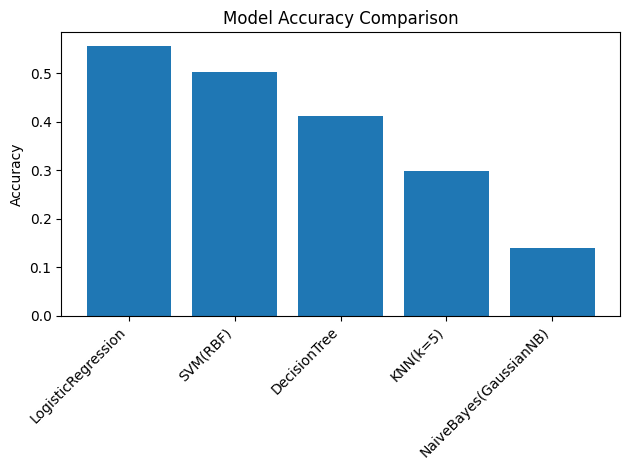

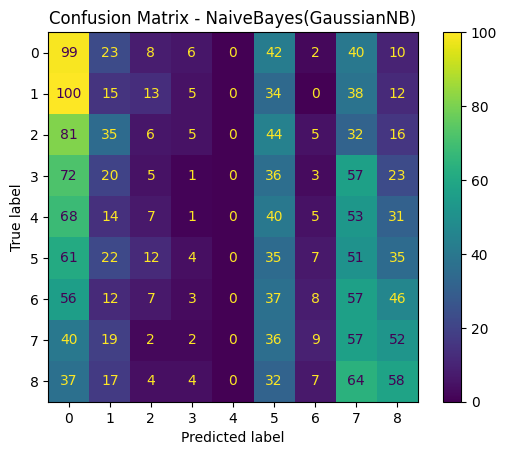

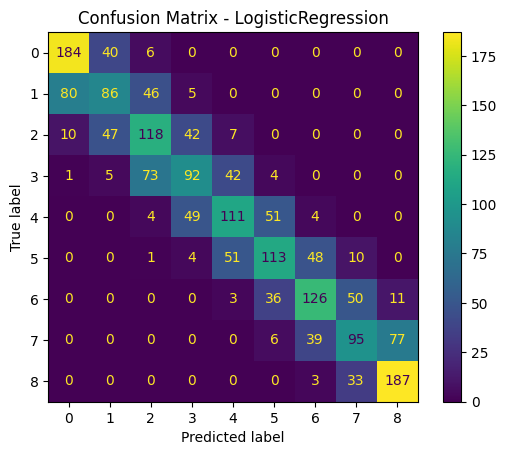

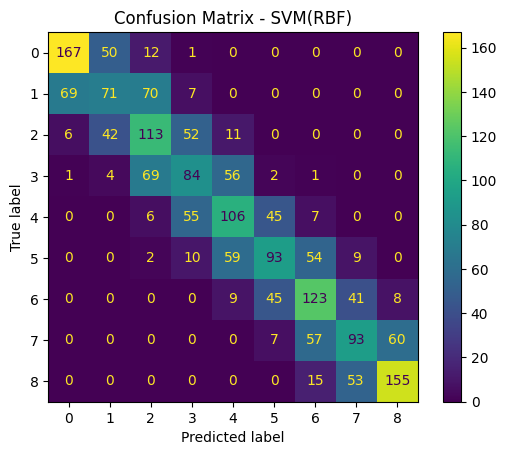

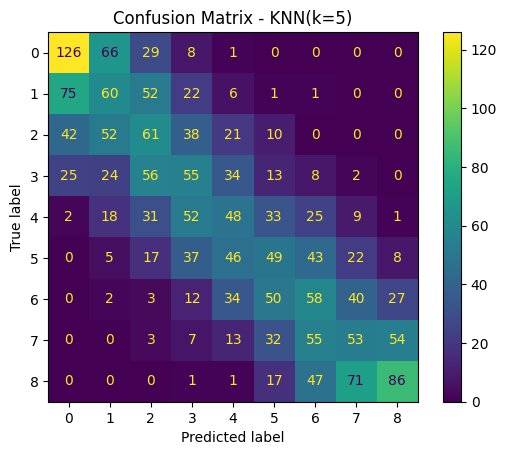

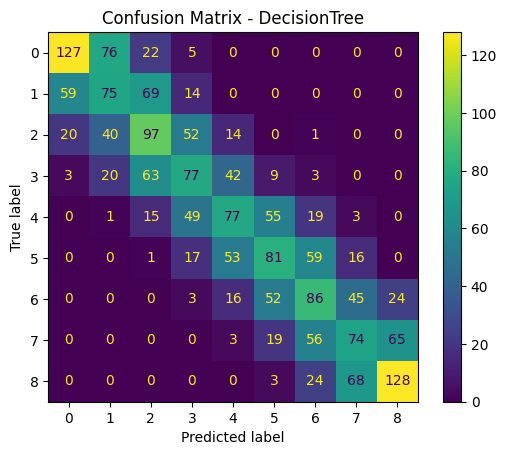

from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Precision_w'].plot(kind='hist', bins=20, title='Precision_w')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Recall_w'].plot(kind='hist', bins=20, title='Recall_w')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='index', y='Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Accuracy', y='Precision_w', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Precision_w', y='Recall_w', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='Recall_w', y='F1_w', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['Precision_w'].plot(kind='line', figsize=(8, 4), title='Precision_w')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['Recall_w'].plot(kind='line', figsize=(8, 4), title='Recall_w')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='index', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='Precision_w', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_16['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_16, x='Recall_w', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [10]:

# Comparison table
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision_w', 'Recall_w', 'F1_w']).sort_values('Accuracy', ascending=False)
display(results_df)

# Bar chart for Accuracy
plt.figure()
plt.bar(results_df['Model'], results_df['Accuracy'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.tight_layout()
plt.show()

# Plot confusion matrices
for name in models.keys():
    cm = reports[name]['cm']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots()
    disp.plot(ax=ax)
    plt.title(f'Confusion Matrix - {name}')
    plt.show()


In [11]:

# Optional: 5-fold CV on Accuracy (quick check)
print("\n5-fold Stratified CV (Accuracy) — this can take more time for SVM on large datasets.")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, pipe in models.items():
    scores = cross_val_score(pipe, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f"{name:25s} CV-Acc: mean={scores.mean():.4f}, std={scores.std():.4f}")



5-fold Stratified CV (Accuracy) — this can take more time for SVM on large datasets.
NaiveBayes(GaussianNB)    CV-Acc: mean=0.1569, std=0.0051
LogisticRegression        CV-Acc: mean=0.5633, std=0.0051
SVM(RBF)                  CV-Acc: mean=0.5096, std=0.0055
KNN(k=5)                  CV-Acc: mean=0.2956, std=0.0075
DecisionTree              CV-Acc: mean=0.4295, std=0.0121
